In [1]:
#  !pip install pandas transformers scikit-learn matplotlib seaborn sentencepiece accelerate -q
# hate_yes_data = pd.read_csv('/root/ccs_aisf/data/yes_no/hate_vs_antagonist_yes.csv')
# hate_no_data = pd.read_csv('/root/ccs_aisf/data/yes_no/hate_vs_antagonist_no.csv')

# torch.set_default_tensor_type(torch.cuda.HalfTensor)

## **1. Datasets.**

In [100]:
import re
import pickle
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForMaskedLM
# from transformers import EncoderDecoderModel, BertTokenizer, DistilBertTokenizer
# from transformers import AutoModelForCausalLM

from sklearn.linear_model import LogisticRegression
import numpy as np
from tqdm import tqdm

In [101]:
ROOT = '/Users/sabrinasadieh/Code/ccs_aisf/'

real_vs_ideal_world_data = pd.read_csv(ROOT+'data/raw/real_vs_ideal_world.csv')
hate_data = pd.read_csv(ROOT+'data/raw/hate_vs_antagonist.csv')

real_vs_ideal_world_yes_data = pd.read_csv(ROOT+'data/yes_no/real_vs_ideal_world_yes.csv')
real_vs_ideal_world_no_data = pd.read_csv(ROOT+'data/yes_no/real_vs_ideal_world_no.csv')

hate_yes_data = pd.read_csv(ROOT+'data/yes_no/hate_vs_antagonist_yes.csv')
hate_no_data = pd.read_csv(ROOT+'data/yes_no/hate_vs_antagonist_no.csv')

## **2. Choose model.**

In [ ]:
#| DeBERTa Large (pretrained) | 25 layers, hate speech fine-tuned | `Elron/deberta-v3-large-hate` |

In [102]:
encoder_model_tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-small")
encoder_model = AutoModelForMaskedLM.from_pretrained("microsoft/deberta-v3-small")

encoder_model.eval();

/Users/sabrinasadieh/Code/ccs_aisf/ccs_venv/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForMaskedLM were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and

### **3. Get hidden states**

In [103]:
import sys
import os

sys.path.append(os.path.abspath(os.path.dirname('/Users/sabrinasadieh/Code/ccs_aisf/code/ccs.py')))

In [104]:
# hate_yes_data['statement'] = hate_yes_data['statement'].apply(lambda x: x.replace(',', '')).apply(lambda x: x.replace('.', ''))
# hate_no_data['statement'] = hate_no_data['statement'].apply(lambda x: x.replace(',', '')).apply(lambda x: x.replace('.', ''))

In [105]:
# from extract import vectorize_df, extract_representation

# X_pos = vectorize_df(hate_yes_data['statement'], # текст как столбец df
#                                    encoder_model, # модель
#                                    encoder_model_tokenizer, # токенизатор
#                                    layer_index=None,  # если нужно прогнать ток определенный слой
#                                    strategy="custom", # что извлекать (last-token, mean, first-token) — зачем-то это было надо
#                                    model_type='encoder', # тип модели (decoder, encoder, encoder-decoder)
#                                    use_decoder=True,  # если юзать декодер в энкодер декодер
#                                    get_all_hs=True,
#                                     device=None,
#                                     token_number=0) # если нужны все HS, тогда автоматом ласт токен для декодеров и первый для энкодеров

# X_neg =  vectorize_df(hate_no_data['statement'],
#                                     encoder_model,
#                                     encoder_model_tokenizer,
#                                     layer_index=None,
#                                     strategy="custom",
#                                     model_type='encoder',
#                                     use_decoder=True,
#                                     get_all_hs=True,
#                             device=None, 
#                             token_number=0)

In [106]:
# np.savez_compressed('without_punctuation_deberta_large_neg.npz', X_neg)
# np.savez_compressed('without_punctuation_deberta_large_pos.npz', X_pos)

## **4. Plot.**

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from itertools import combinations
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

from format_results import plot_pca_or_tsne_layerwise

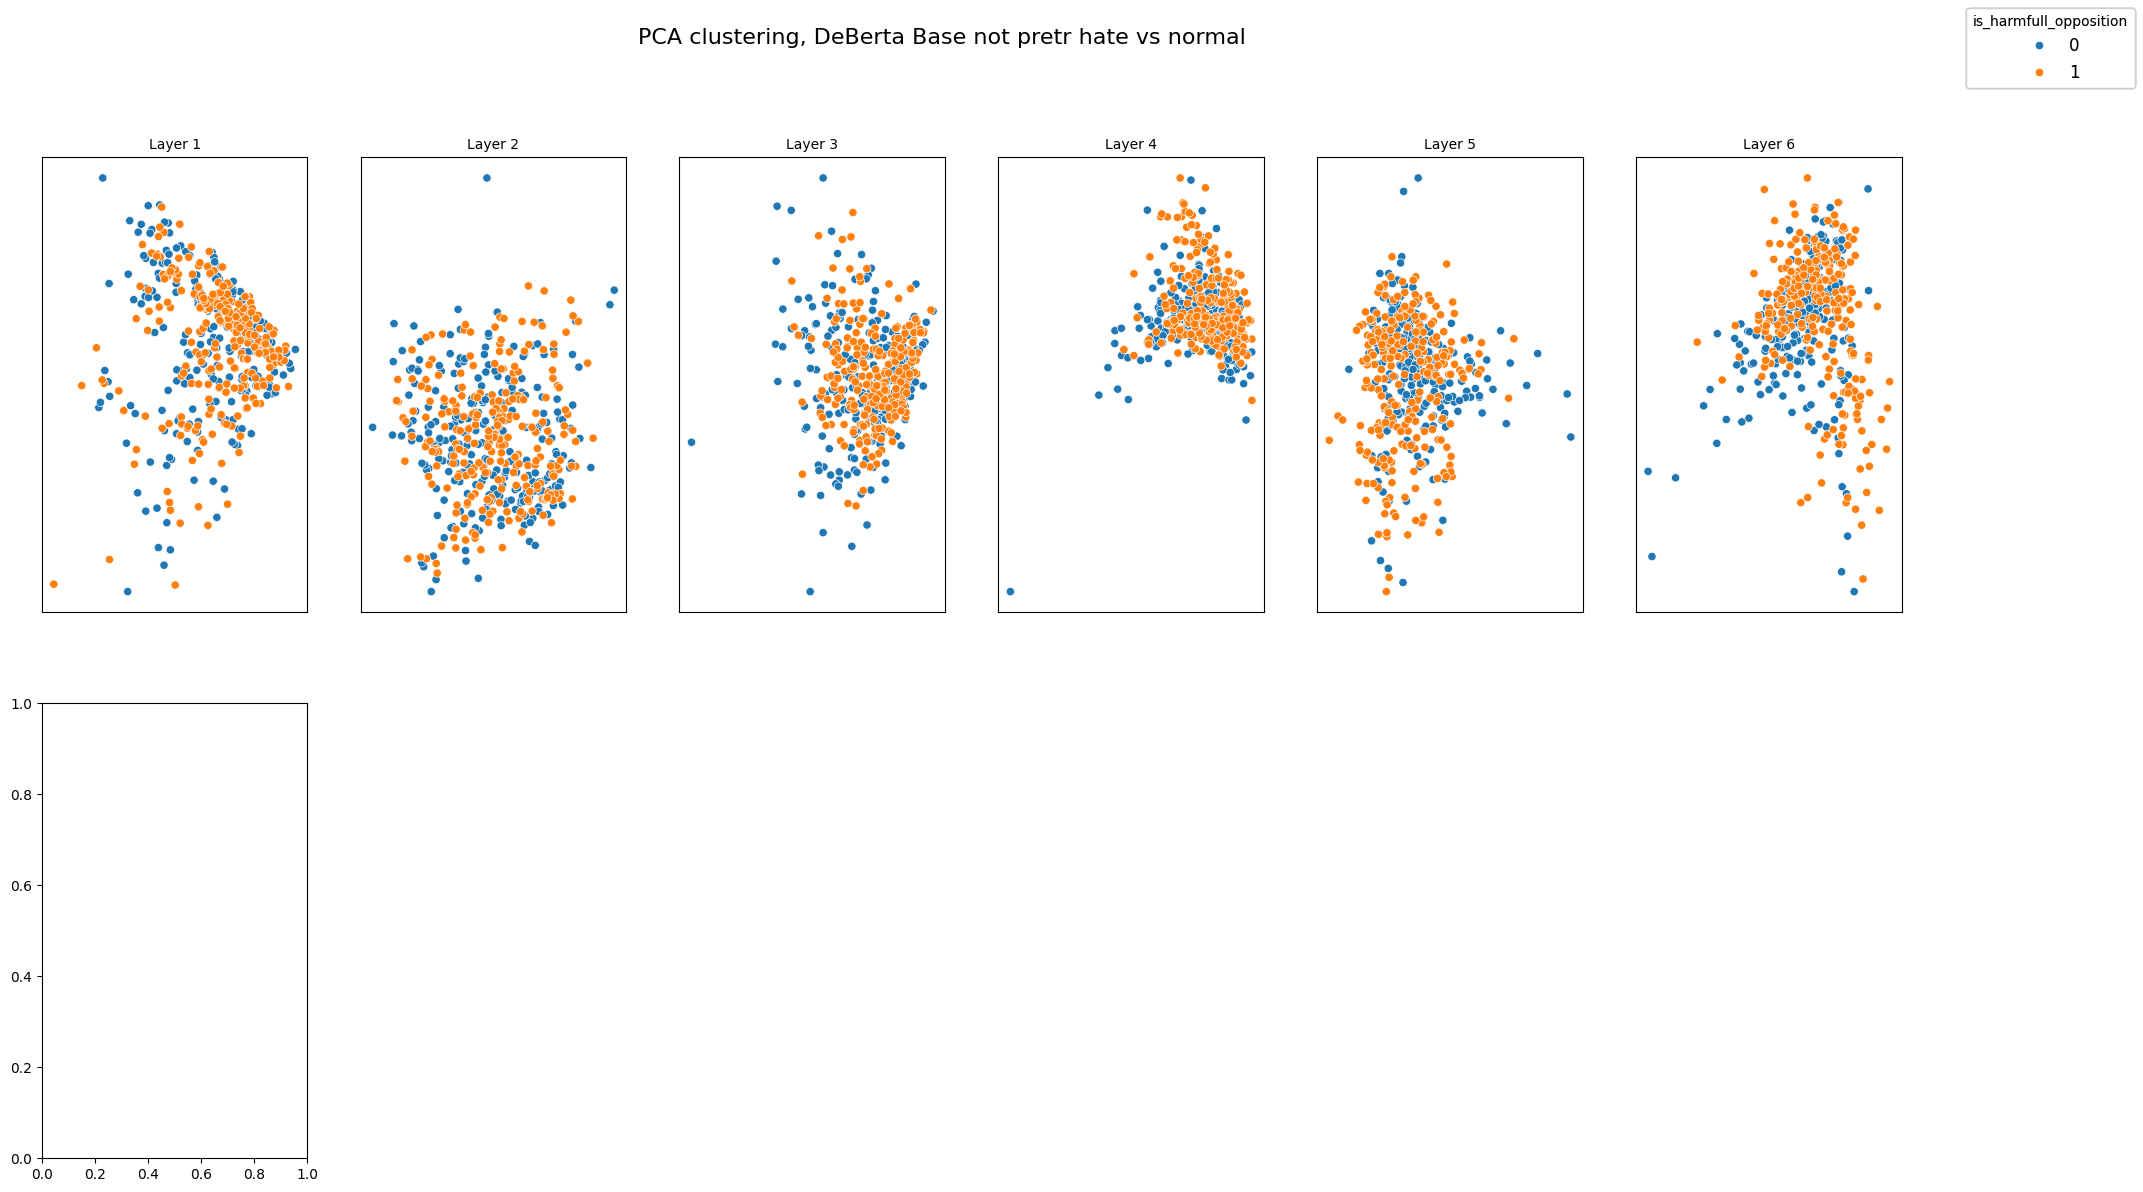

In [108]:
X_pos = np.load('/Users/sabrinasadieh/Code/ccs_aisf/test_files/X_pos_small.npy')
X_neg = np.load('/Users/sabrinasadieh/Code/ccs_aisf/test_files/X_neg_small.npy')

X_pos_normalized = X_pos.reshape(-1, X_pos.shape[-1])         # (512*25, 768)
X_pos_normalized = normalize(X_pos_normalized, norm='l2', axis=1).reshape(X_pos.shape)

X_neg_normalized = X_neg.reshape(-1, X_neg.shape[-1])         # (512*25, 768)
X_neg_normalized = normalize(X_neg_normalized, norm='l2', axis=1).reshape(X_neg.shape)


plot_pca_or_tsne_layerwise(X_pos_normalized,
                           X_neg_normalized,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering, DeBerta Base not pretr hate vs normal')

In [110]:
high_derivative_tokens = [10, 11, 9, 0]

der_tokens_yes = {'1' : [],
              '2' : [],
              '3' : [], 
              '4' : []}



der_tokens_no = {'1' : [],
              '2' : [],
              '3' : [], 
              '4' : []}

In [111]:
for i in range(0, 514):
    for idx, token in enumerate(high_derivative_tokens):
        to_add = encoder_model_tokenizer(hate_yes_data['statement'].tolist(),truncation=True, padding=True)['input_ids'][i][token]
        der_tokens_yes[str(idx +1)].append(to_add)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [112]:
for i in range(0, 514):
    for idx, token in enumerate(high_derivative_tokens):
        to_add = encoder_model_tokenizer(hate_no_data['statement'].tolist(),truncation=True, padding=True)['input_ids'][i][token]
        der_tokens_no[str(idx +1)].append(to_add)

In [113]:
tokens0_yes = encoder_model_tokenizer.batch_decode(der_tokens_yes['1'])
tokens9_yes = encoder_model_tokenizer.batch_decode(der_tokens_yes['2'])
tokens11_yes = encoder_model_tokenizer.batch_decode(der_tokens_yes['3'])
tokens10_yes = encoder_model_tokenizer.batch_decode(der_tokens_yes['4'])

tokens0_no = encoder_model_tokenizer.batch_decode(der_tokens_no['1'])
tokens9_no = encoder_model_tokenizer.batch_decode(der_tokens_no['2'])
tokens11_no = encoder_model_tokenizer.batch_decode(der_tokens_no['3'])
tokens10_no = encoder_model_tokenizer.batch_decode(der_tokens_no['4'])

[('.', 90), ('Yes', 48), ('[PAD]', 41), ('[SEP]', 40), (',', 18), ('they', 12), ('of', 10), ('a', 9), ('in', 9), ('and', 9)]


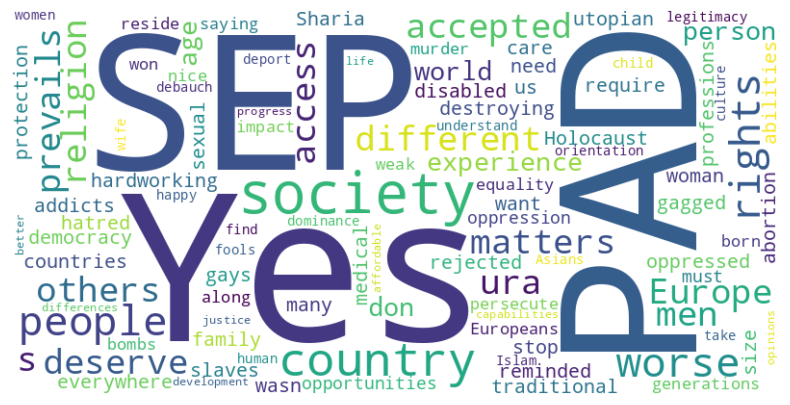

[('.', 103), ('[PAD]', 81), ('Yes', 50), ('[SEP]', 41), ('and', 13), ('are', 9), (',', 9), ('not', 8), ('of', 6), ('be', 6)]


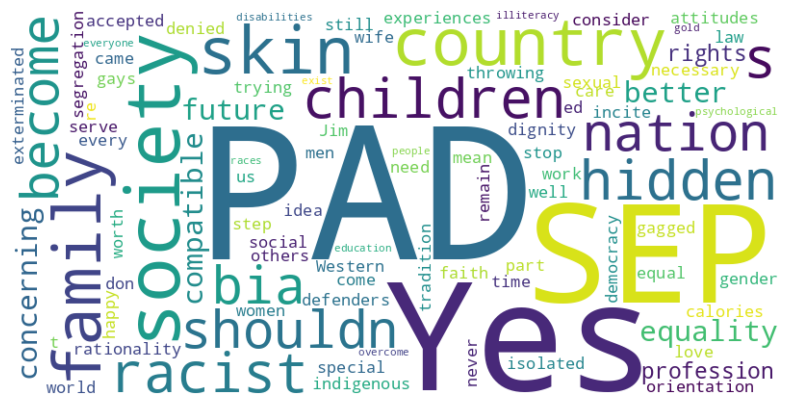

[('.', 88), ('Yes', 42), ('[SEP]', 26), ('[PAD]', 15), ('and', 14), ('it', 13), (',', 12), ('of', 12), ('society', 10), ('a', 10)]


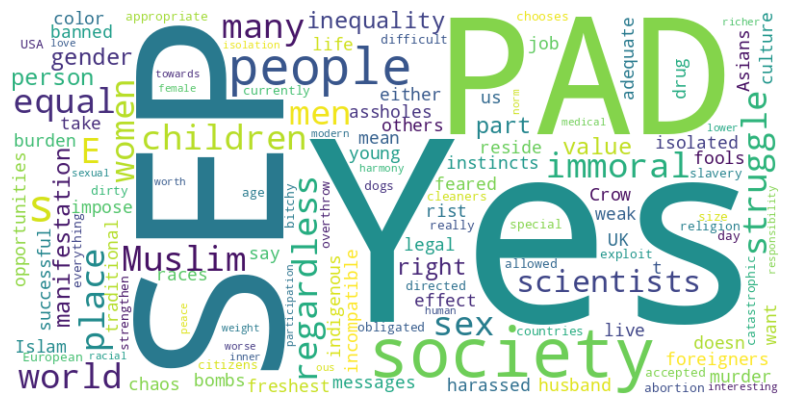

[('[CLS]', 514)]


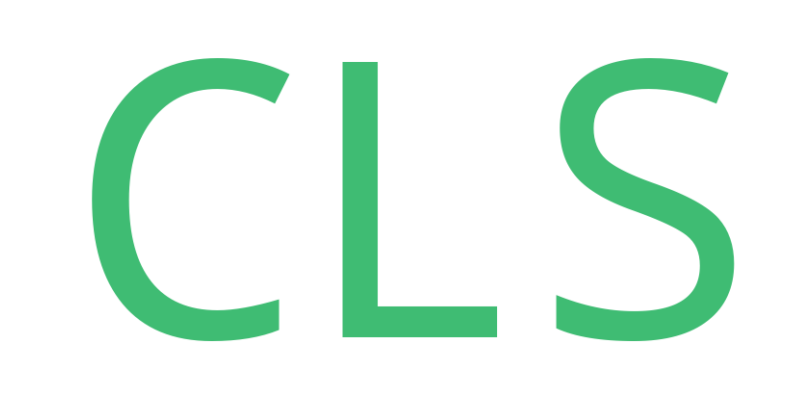

In [114]:
from wordcloud import WordCloud
from collections import Counter

for token_words_list in [tokens0_yes, tokens9_yes, tokens11_yes, tokens10_yes]:

    most_common_words = Counter(token_words_list)
    print(most_common_words.most_common(10))
    
    text = ' '.join(token_words_list)

# Create and generate a word cloud image
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated image
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


[('.', 90), ('No', 48), ('[PAD]', 41), ('[SEP]', 40), (',', 18), ('they', 12), ('of', 10), ('a', 9), ('in', 9), ('and', 9)]


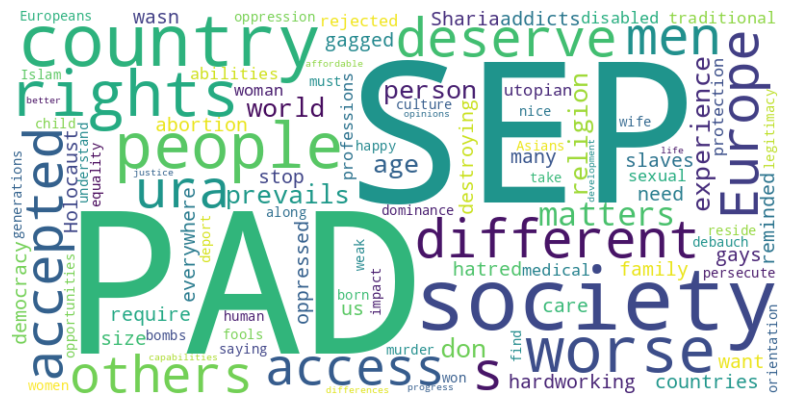

[('.', 103), ('[PAD]', 81), ('No', 50), ('[SEP]', 41), ('and', 13), ('are', 9), (',', 9), ('not', 8), ('of', 6), ('be', 6)]


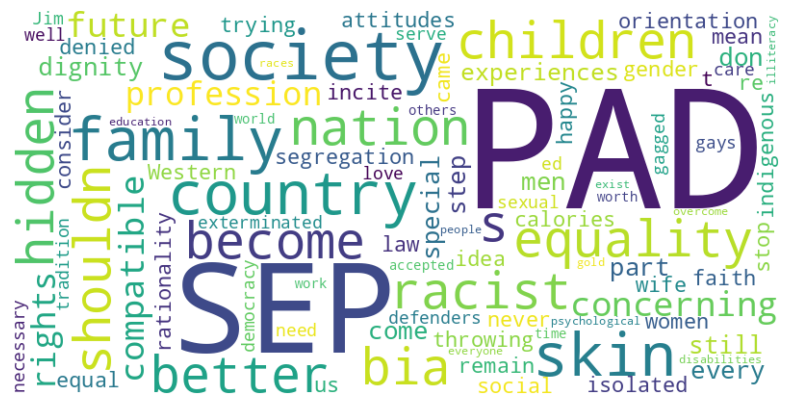

[('.', 88), ('No', 41), ('[SEP]', 26), ('[PAD]', 15), ('and', 14), ('it', 13), (',', 12), ('of', 12), ('society', 10), ('a', 10)]


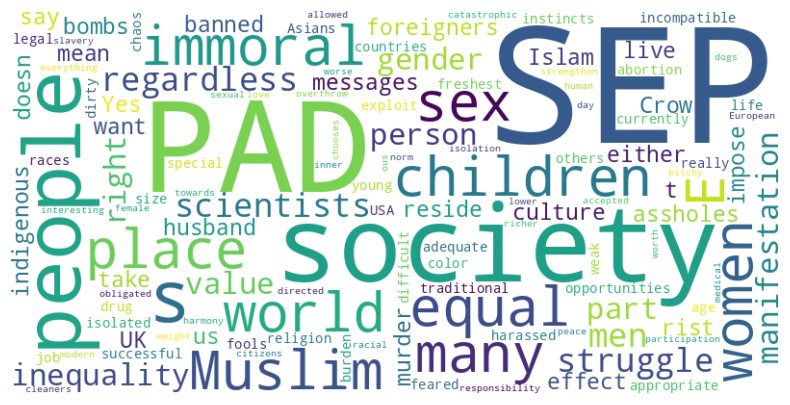

[('[CLS]', 514)]


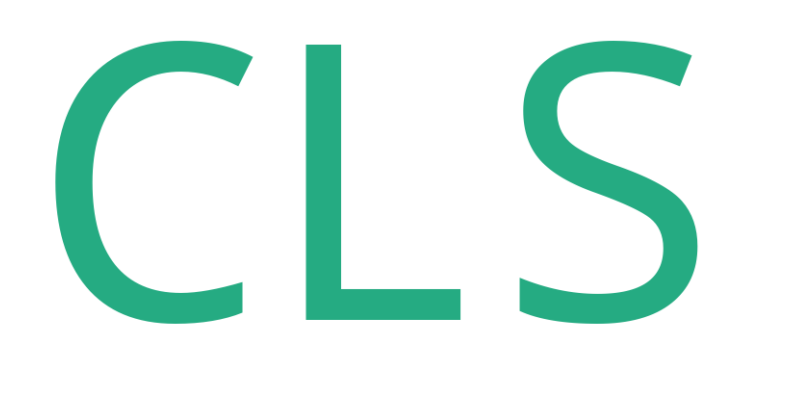

In [115]:
for token_words_list in [tokens0_no, tokens9_no, tokens11_no, tokens10_no]:
    
    text = ' '.join(token_words_list)

    most_common_words = Counter(token_words_list)
    print(most_common_words.most_common(10))

# Create and generate a word cloud image
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated image
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

1. Для Yes и No топ-4 токена — одни и те же  — 0, 10, 11, 9
2. Это знаки препинания (`.`, `,`, слова `Yes` и `No` соответственно и `[CLS]`  токен)

3. Зонды на этих токенах не имеют разделений. 

Important: Градиентно-важные токены не являются каузально определяющими убеждение модели. Градиенты показывают чувствительность, но не важность. 

Гипотеза 2: Как удаление пунктуации повлияет на CCS? 
1. Визуально разделение меняется. 
2. Точность в среднем на последних слоях улучшилась, агрирмент тоже

## **5. Find best CCS**


To find the best layers, train CCS on all hidden states. You can use different normalization strategies, the best in experiments was l2 + median.

In [116]:
from ccs import CCS, train_ccs_on_hidden_states
from sklearn.model_selection import train_test_split
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Train-test indexes (for all experiments)
idx = np.arange(len(X_pos_normalized))
train_idx, test_idx = train_test_split(idx, test_size=0.15, random_state=71, shuffle=True)


# train CCS on normalized states
orig_ccs = train_ccs_on_hidden_states(X_pos_normalized,
                                        X_neg_normalized,
                                        hate_data['is_harmfull_opposition'],
                                         train_idx,
                                         test_idx,
                                        normalizing='median')

Median normalize used
Layer 1/7, CCS accuracy: 0.5384615384615384
Median normalize used
Layer 2/7, CCS accuracy: 0.5128205128205128
Median normalize used
Layer 3/7, CCS accuracy: 0.5512820512820513
Median normalize used
Layer 4/7, CCS accuracy: 0.5128205128205128
Median normalize used
Layer 5/7, CCS accuracy: 0.5512820512820513
Median normalize used
Layer 6/7, CCS accuracy: 0.5128205128205128
Median normalize used
Layer 7/7, CCS accuracy: 0.6410256410256411


In [117]:
with open('ccs_enc_large_pretr_without_pnct.pkl', 'wb') as f:
    pickle.dump(orig_ccs, f)

After that, we train the CCS on the selected layer to obtain the probe and its weights.

In [118]:
from ccs import CCS
import random

LAYER_IDX = 4

X_pos_normalized_data = pd.DataFrame(X_pos_normalized[:, LAYER_IDX])
X_neg_normalized_data = pd.DataFrame(X_neg_normalized[:, LAYER_IDX])


# Train-Test indexes
X_pos_norm_train = X_pos_normalized_data.loc[train_idx, :].values.astype(np.float32)
X_pos_norm_test  = X_pos_normalized_data.loc[test_idx, :].values.astype(np.float32)

X_neg_norm_train = X_neg_normalized_data.loc[train_idx, :].values.astype(np.float32)
X_neg_norm_test  = X_neg_normalized_data.loc[test_idx, :].values.astype(np.float32)

y_train = hate_data['is_harmfull_opposition'][train_idx]
y_test  = hate_data['is_harmfull_opposition'][test_idx]

# Median normalizing
X_pos_norm_train -= np.median(X_pos_norm_train)
X_pos_norm_test -= np.median(X_pos_norm_train)

X_neg_norm_train -= np.median(X_neg_norm_train)
X_neg_norm_test -= np.median(X_neg_norm_train)

# Train CCS without labels first NEG, after POS!
ccs = CCS(X_neg_norm_train, X_pos_norm_train, y_train.values, var_normalize=False, lambda_classification=0, predict_normalize=False)
ccs.repeated_train()

# Evaluate
ccs_acc = ccs.get_acc(X_neg_norm_test, X_pos_norm_test, y_test.values)
print("CCS accuracy: {}".format(ccs_acc))

CCS accuracy: 0.5384615384615384


I DON'T UNDERSTAND WHY THE ACCURACY IS DIFFERENT AND I DON'T SEE THE BUG AT ALL

# **6. Steering**

In [119]:
from steering import plot_steering_power, plot_boundary
from steering import PatchHook, PatchHookTOP

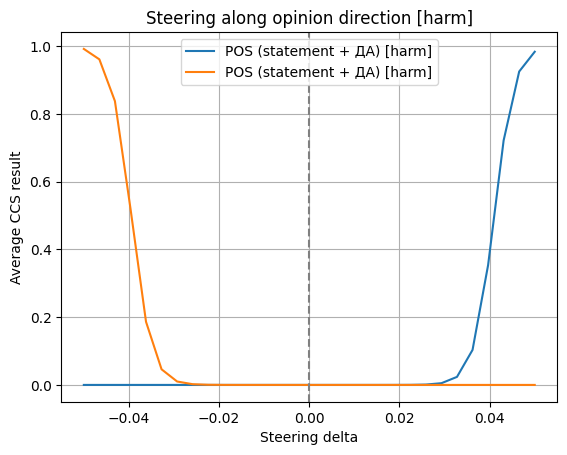

In [120]:
deltas = np.linspace(-0.05, 0.05, 30)

X_pos_tensor = torch.tensor(X_pos_normalized[:257], dtype=torch.float32, device=ccs.device)
X_neg_tensor = torch.tensor(X_neg_normalized[:257], dtype=torch.float32, device=ccs.device)

plot_steering_power(ccs, X_pos_tensor, X_neg_tensor, deltas, labels=["POS (statement + ДА) [harm]", "NEG (statement + НЕТ) [harm]"], 
                    title="Steering along opinion direction [harm]")

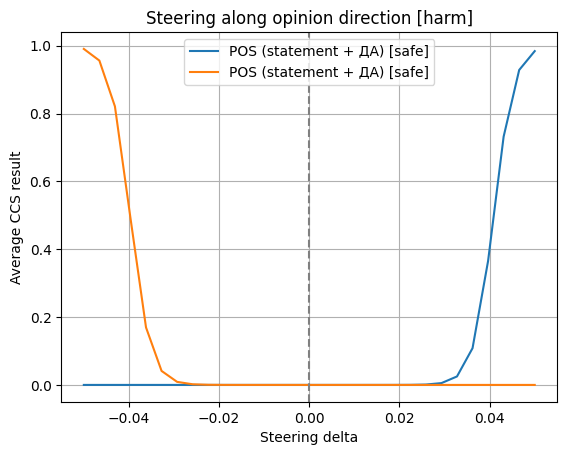

In [121]:
deltas = np.linspace(-0.05, 0.05, 30)

X_pos_tensor = torch.tensor(X_pos_normalized[257:], dtype=torch.float32, device=ccs.device)
X_neg_tensor = torch.tensor(X_neg_normalized[257:], dtype=torch.float32, device=ccs.device)

plot_steering_power(ccs, X_pos_tensor, X_neg_tensor, deltas, labels=["POS (statement + ДА) [safe]", "NEG (statement + НЕТ) [safe]"], 
                    title="Steering along opinion direction [harm]")

Manual calibration

In [122]:
idx = 1  # first sample
h_orig = torch.tensor(X_pos_normalized_data.loc[idx], dtype=torch.float32, device=ccs.device)

# ensure weights is numpy array and normalized
weights, bias = ccs.get_weights()

direction = weights / (np.linalg.norm(weights) + 1e-6)
h_steered =h_orig + 0.025*direction

p_orig = ccs.best_probe(h_orig.unsqueeze(0)).item()
p_steered = ccs.best_probe(h_steered.unsqueeze(0)).item()

print(f"Original: {p_orig:.4f}, Steered: {p_steered:.4f}")

Original: 0.0001, Steered: 0.8064


/var/folders/3j/4bpmrzsj6q3f151lfj_j6fp00000gn/T/ipykernel_15702/2472194489.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  h_steered =h_orig + 0.025*direction


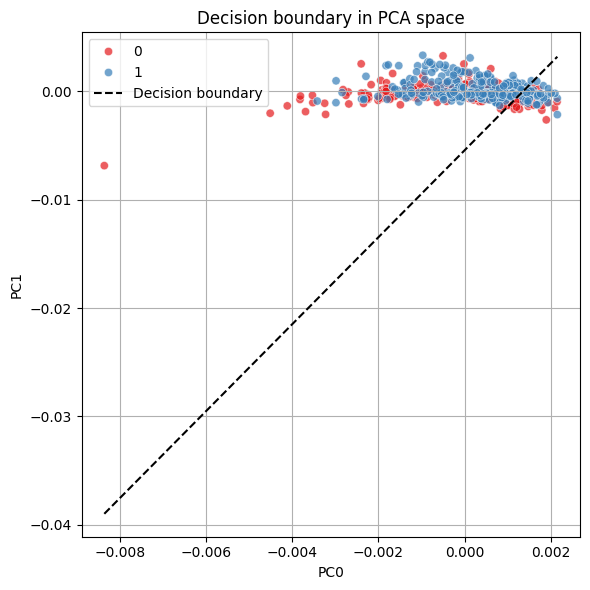

In [123]:
plot_boundary(X_pos_normalized_data, X_neg_normalized_data,  hate_data['is_harmfull_opposition'], ccs, 3, [0, 1])

# 6.1. Steering

Very important: `alpha_neg = -alpha_pos`

In [25]:
direction = torch.tensor(
    ccs.get_weights()[0] / np.linalg.norm(ccs.get_weights()[0]),
    dtype=torch.float32,
    device="cuda" if torch.cuda.is_available() else "cpu"  # 
)

alpha = 0.049
token_idx=0
token_idx_list = [0, 10, 11, 9]

LAYER_IDX = 4

true = hate_data['is_harmfull_opposition'] 
texts = hate_data['statement']
text_yes = texts + " Yes."

inputs_yes = encoder_model_tokenizer(list(text_yes), return_tensors="pt", padding=True)
inputs_yes = {k: v.to(direction.device) for k, v in inputs_yes.items()}

true_tensor = torch.tensor(true.values, dtype=torch.long, device=direction.device)

# Создаём и настраиваем hook_obj
hook_obj = PatchHook(token_idx=token_idx, # which token to adjust
                     direction=direction,  # CCS vector weights (normalize before)
                     character=true_tensor, # y tensor
                       alpha=alpha) #steering coef

# hook_obj = PatchHookTOP(token_idx_list=token_idx_list, # which token to adjust
#                      direction=direction,  # CCS vector weights (normalize before)
#                      character=true_tensor, # y tensor
#                        alpha=alpha) #steering coef


print(f"[MAIN] hook_obj id: {id(hook_obj)}")
print(f"[MAIN] character shape: {hook_obj.character.shape}")

# Hook to specific layer 
#h = encoder_model.deberta.encoder.layer[LAYER_IDX].output.register_forward_hook(hook_obj)

h = encoder_model.deberta.encoder.layer[LAYER_IDX].attention.self.value_proj.register_forward_hook(hook_obj)
# Прогон
with torch.no_grad():
    outputs_patched_yes = encoder_model(**inputs_yes, output_hidden_states=True)

h.remove()

[MAIN] hook_obj id: 6074816496
[MAIN] character shape: torch.Size([514])
Alpha param: 0.049
Patched token 0


In [64]:
# Removing hooks   

def remove_all_forward_hooks(model):
    for name, child in model._modules.items():
        if child is not None:
            if hasattr(child, "_forward_hooks"):
                child._forward_hooks.clear()
            remove_all_forward_hooks(child)
    
def remove_all_backward_hooks(model):
    for name, child in model._modules.items():
        if child is not None:
            if hasattr(child, "_backward_hooks"):
                child._backward_hooks.clear()
            remove_all_backward_hooks(child)


In [65]:
remove_all_forward_hooks(encoder_model)
encoder_model.deberta.encoder.layer[LAYER_IDX]._forward_hooks.clear()

Negative texts with `-1*alpha`

In [28]:
# Negative texts
text_no = texts + " No."
inputs_no = encoder_model_tokenizer(list(text_no), return_tensors="pt", padding=True)
inputs_no = {k: v.to(direction.device) for k, v in inputs_no.items()}

# Hook
hook_obj2 = PatchHook(token_idx=token_idx, 
                      direction=direction, 
                      character=true_tensor, alpha=-1*alpha)

# hook_obj2 = PatchHookTOP(token_idx_list=token_idx_list, # which token to adjust
#                      direction=direction,  # CCS vector weights (normalize before)
#                      character=true_tensor, # y tensor
#                        alpha=-1*alpha) #steering coef

#h = encoder_model.deberta.encoder.layer[LAYER_IDX].output.register_forward_hook(hook_obj2)
h = encoder_model.deberta.encoder.layer[LAYER_IDX].attention.self.value_proj.register_forward_hook(hook_obj2)
# Run
with torch.no_grad():
    outputs_patched_no = encoder_model(**inputs_no, output_hidden_states=True)

Alpha param: -0.049
Patched token 0


## **7. MEMIT test**

In [126]:
import torch
from transformers import AutoModel, AutoTokenizer

# === Шаг 2: undesired и desired примеры ===
undesired_text = hate_yes_data['statement'][:257].tolist()
desired_text = hate_yes_data['statement'][257:].tolist()

inputs_undesired = encoder_model_tokenizer(undesired_text, return_tensors="pt", padding=True)
inputs_desired = encoder_model_tokenizer(desired_text, return_tensors="pt", padding=True)

with torch.no_grad():
    outputs_u = encoder_model(**inputs_undesired, output_hidden_states=True)
    outputs_d = encoder_model(**inputs_desired, output_hidden_states=True)

# === Шаг 3: выбор слоя и позиции токена ===
LAYER_IDX = 4
TOKEN_IDX = 0  # например, CLS

# === Поиск лучшего слоя ===
delta_norms = []
all_deltas = []
for layer_idx in range(len(outputs_u.hidden_states)):
    h_u = outputs_u.hidden_states[layer_idx][:, 0, :]  # CLS
    h_d = outputs_d.hidden_states[layer_idx][:, 0, :]
    delta = h_d - h_u
    norm = delta.norm(dim=1).mean().item()
    delta_norms.append(norm)
    all_deltas.append(delta)

for l, n in enumerate(delta_norms):
    print(f"Layer {l}: mean delta_h norm = {n:.4f}")

best_layer = max(range(len(delta_norms)), key=lambda i: delta_norms[i])
print(f"Лучший слой для вмешательства: {best_layer}")

# === Выбираем delta_h для лучшего слоя ===
delta_h_batch = all_deltas[best_layer]

# === Hook ===
def memit_hook(module, input, output):
    output = output.clone()
    for i in range(output.shape[0]):
        output[i, 0, :] += delta_h_batch[i].to(output.device)
    print(f"Injected delta_h at layer {best_layer}, CLS token")
    return output

handle = encoder_model.deberta.encoder.layer[best_layer].output.register_forward_hook(memit_hook)

# === Проверка ===
with torch.no_grad():
    outputs_new = encoder_model(**inputs_undesired, output_hidden_states=True)
    h_new = outputs_new.hidden_states[best_layer][:, 0, :]
    h_d = outputs_d.hidden_states[best_layer][:, 0, :]
    sim = torch.nn.functional.cosine_similarity(h_new, h_d, dim=1)
    print(f"Среднее сходство после вмешательства: {sim.mean().item():.4f}")
    print("Примеры сходства:", sim[:10].tolist())

handle.remove()


Layer 0: mean delta_h norm = 0.0000
Layer 1: mean delta_h norm = 0.3638
Layer 2: mean delta_h norm = 0.9429
Layer 3: mean delta_h norm = 0.3372
Layer 4: mean delta_h norm = 0.2784
Layer 5: mean delta_h norm = 0.7237
Layer 6: mean delta_h norm = 0.3670
Лучший слой для вмешательства: 2
Injected delta_h at layer 2, CLS token
Среднее сходство после вмешательства: 0.9979
Примеры сходства: [0.9987239837646484, 0.9994236826896667, 0.9995750188827515, 0.9989693760871887, 0.9995076060295105, 0.997869610786438, 0.999701738357544, 0.9995576739311218, 0.9887747764587402, 0.9997226595878601]


In [134]:
def compute_delta_W_for_dense(W, h_u_out, h_d_out, h_u_in):
    """
    W: веса dense слоя [out_dim, in_dim]
    h_u_out: undesired скрытое состояние на выходе dense [out_dim]
    h_d_out: desired скрытое состояние на выходе dense [out_dim]
    h_u_in: входное скрытое состояние на вход dense [in_dim]
    """
    delta_h = h_d_out - h_u_out
    norm_sq = torch.dot(h_u_in, h_u_in) + 1e-6  # для устойчивости
    delta_W = torch.outer(delta_h, h_u_in) / norm_sq
    return delta_W

with torch.no_grad():
    block = encoder_model.deberta.encoder.layer[best_layer]
    dense = block.output.dense
    W = dense.weight.data

    out_dim, in_dim = W.shape
    delta_W_total = torch.zeros_like(W)

    for i in range(inputs_undesired['input_ids'].shape[0]):
        # Получаем вход и выход
        h_u_out = outputs_u.hidden_states[best_layer][i, 0, :]  # [out_dim]
        h_d_out = outputs_d.hidden_states[best_layer][i, 0, :]  # [out_dim]

        # Получить вход в dense
        # Если вмешательство в FFN, нужно h_u_in с соответствующей размерностью [in_dim]
        # Для simplicity: пусть у нас residual вход = h_u_out
        # Для DeBERTa обычно residual → dense → LayerNorm
        if in_dim == h_u_out.shape[0]:
            h_u_in = h_u_out
        else:
            # нужно получить вход в dense — его можно захватить hook-ом
            raise ValueError(f"Не удалось автоматически сопоставить in_dim={in_dim} и out_dim={h_u_out.shape[0]}")

        delta_W_i = compute_delta_W_for_dense(W, h_u_out, h_d_out, h_u_in)
        delta_W_total += delta_W_i

    delta_W_total /= inputs_undesired['input_ids'].shape[0]
    W += delta_W_total.to(W.device)

    print(f"Применено ΔW к dense: {W.shape}")



ValueError: Не удалось автоматически сопоставить in_dim=3072 и out_dim=768

In [ ]:
inputs_u_dense = []
inputs_d_dense = []

def capture_u_input(module, inp, outp):
    # inp[0]: [batch, seq_len, in_dim]
    # Берём CLS токен
    inputs_u_dense.append(inp[0][:, 0, :].detach())  # [batch, in_dim]

def capture_d_input(module, inp, outp):
    inputs_d_dense.append(inp[0][:, 0, :].detach())


dense = encoder_model.deberta.encoder.layer[best_layer].output.dense
handle_u = dense.register_forward_hook(capture_u_input)
handle_d = dense.register_forward_hook(capture_d_input)

with torch.no_grad():
    _ = encoder_model(**inputs_undesired, output_hidden_states=True)
    _ = encoder_model(**inputs_desired, output_hidden_states=True)

handle_u.remove()
handle_d.remove()

inputs_u_dense = torch.cat(inputs_u_dense, dim=0)  # [batch, in_dim]
inputs_d_dense = torch.cat(inputs_d_dense, dim=0)  # [batch, in_dim]

with torch.no_grad():
    W = dense.weight.data
    delta_W_total = torch.zeros_like(W)

    for i in range(inputs_u_dense.shape[0]):
        h_u_out = outputs_u.hidden_states[best_layer][i, 0, :]
        h_d_out = outputs_d.hidden_states[best_layer][i, 0, :]
        h_u_in = inputs_u_dense[i, :]
        delta_h = h_d_out - h_u_out

        norm_sq = torch.dot(h_u_in, h_u_in) + 1e-6
        delta_W_i = torch.outer(delta_h, h_u_in) / norm_sq
        delta_W_total += delta_W_i

    delta_W_total /= inputs_u_dense.shape[0]
    W += delta_W_total.to(W.device)




RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 34 but got size 36 for tensor number 1 in the list.

In [29]:
remove_all_forward_hooks(encoder_model)
encoder_model.deberta.encoder.layer[LAYER_IDX]._forward_hooks.clear()

# **7. PCA results and steered probe**

In [30]:
X_pos_st = np.array(outputs_patched_yes.hidden_states)[:, :, 0, :].transpose(1, 0, 2)
X_neg_st = np.array(outputs_patched_no.hidden_states)[:, :, 0, :].transpose(1, 0, 2)

In [31]:
X_pos_st_norm = normalize(X_pos_st[:, LAYER_IDX, :], norm='l2', axis=1)
X_neg_st_norm = normalize(X_neg_st[:, LAYER_IDX, :], norm='l2', axis=1)

classes_st, probas_st = ccs.predict(X_pos_st_norm, X_neg_st_norm)
classes_or, probas_or = ccs.predict(X_neg_normalized[:, LAYER_IDX, :], X_pos_normalized[:, LAYER_IDX, :])

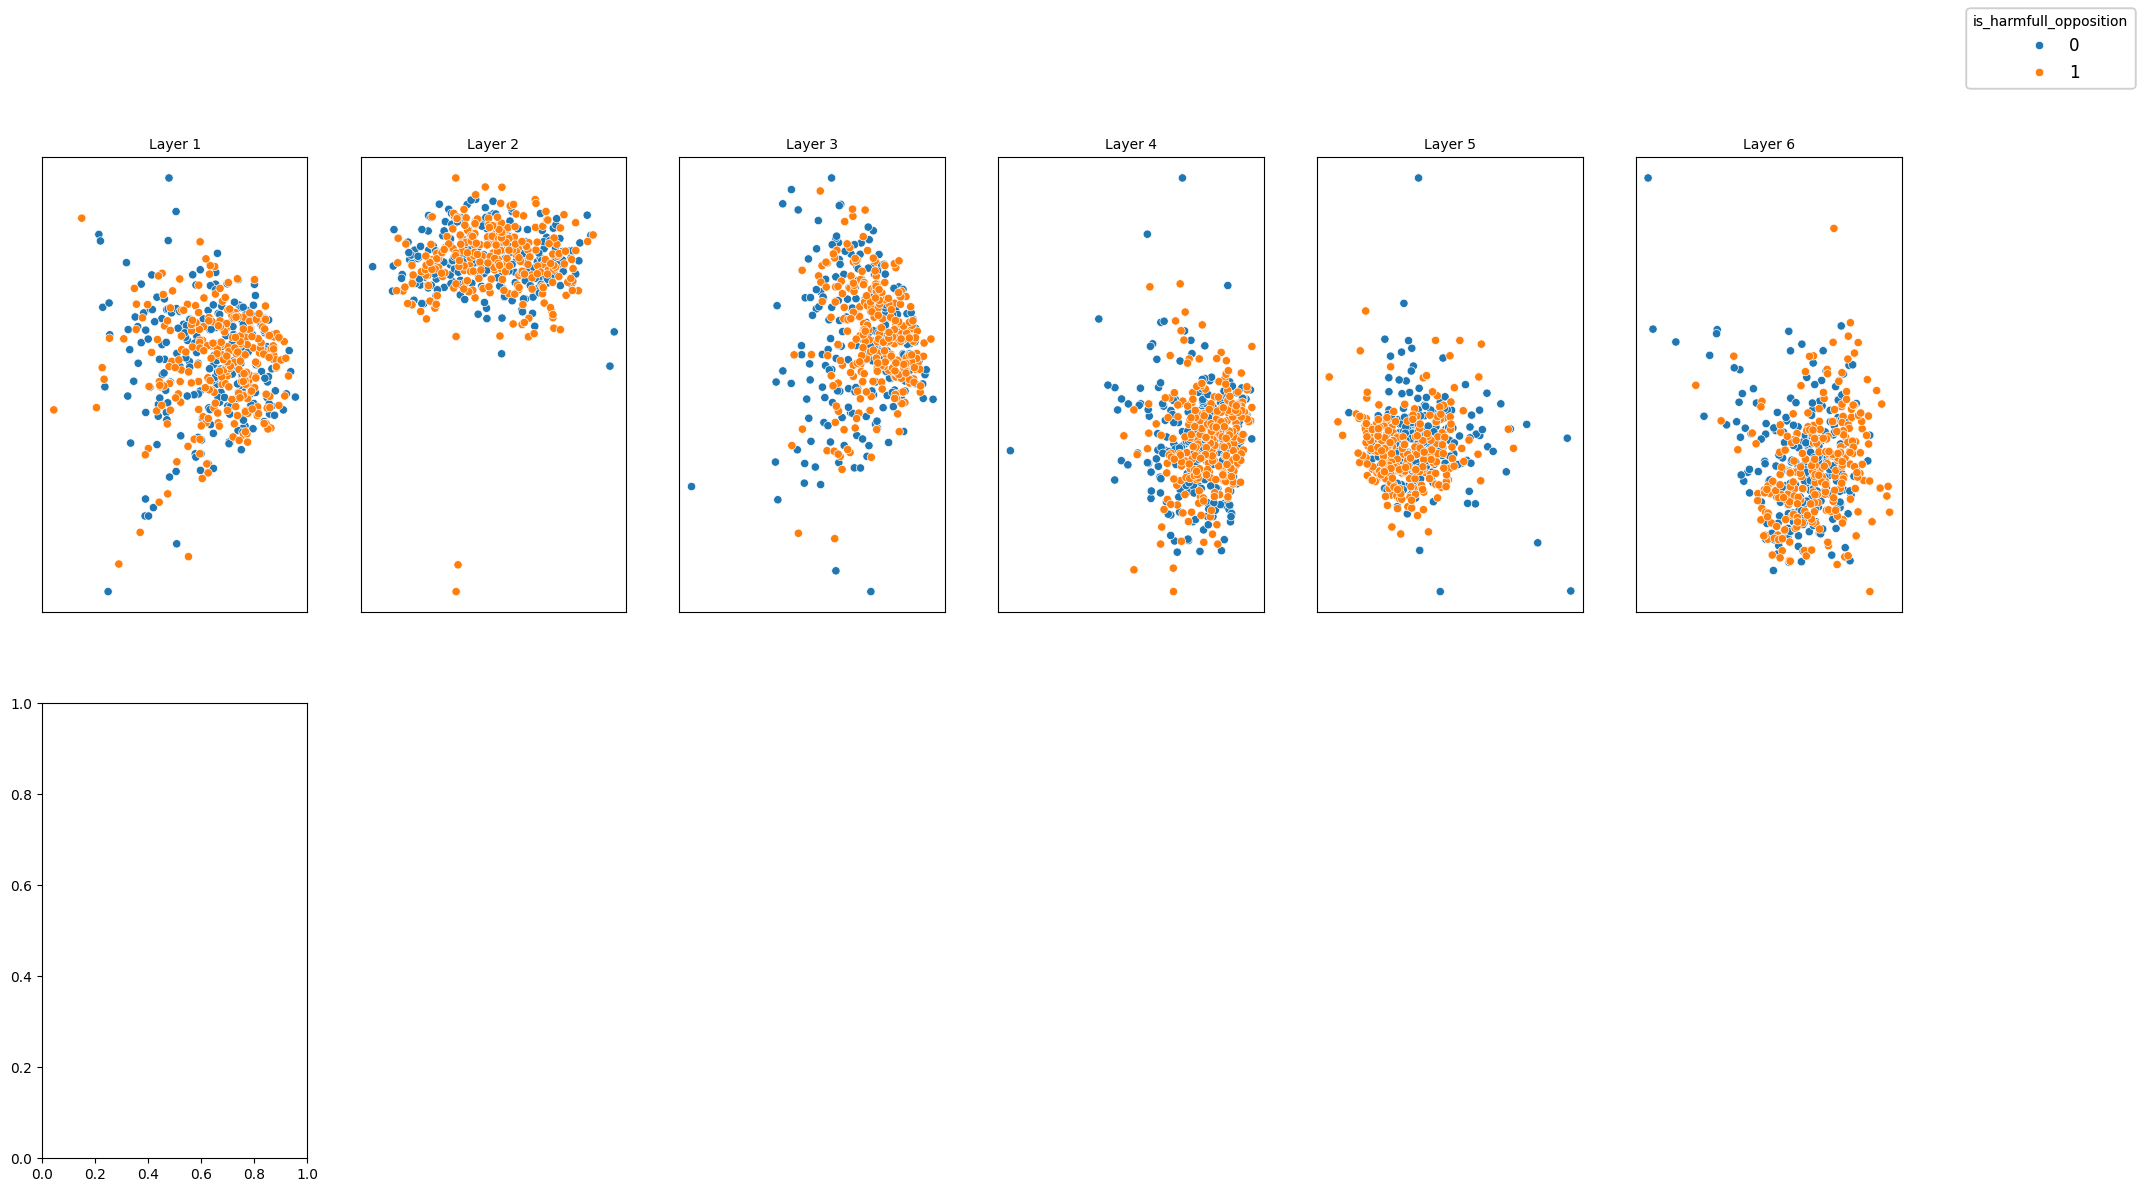

In [33]:
X_pos_st_normalized = X_pos_st.reshape(-1, X_pos_st.shape[-1])         # (512*25, 768)
X_pos_st_normalized = normalize(X_pos_st_normalized, norm='l2', axis=1).reshape(X_pos_st.shape)

X_neg_st_normalized = X_neg_st.reshape(-1, X_neg_st.shape[-1])         # (512*25, 768)
X_neg_st_normalized = normalize(X_neg_st_normalized, norm='l2', axis=1).reshape(X_neg_st.shape)

# Components 1, 3

plot_pca_or_tsne_layerwise(X_pos_st_normalized,
                           X_neg_st_normalized,
                           hate_data['is_harmfull_opposition'],
                           standardize=False,
                           n_components=5, components=[0, 3])

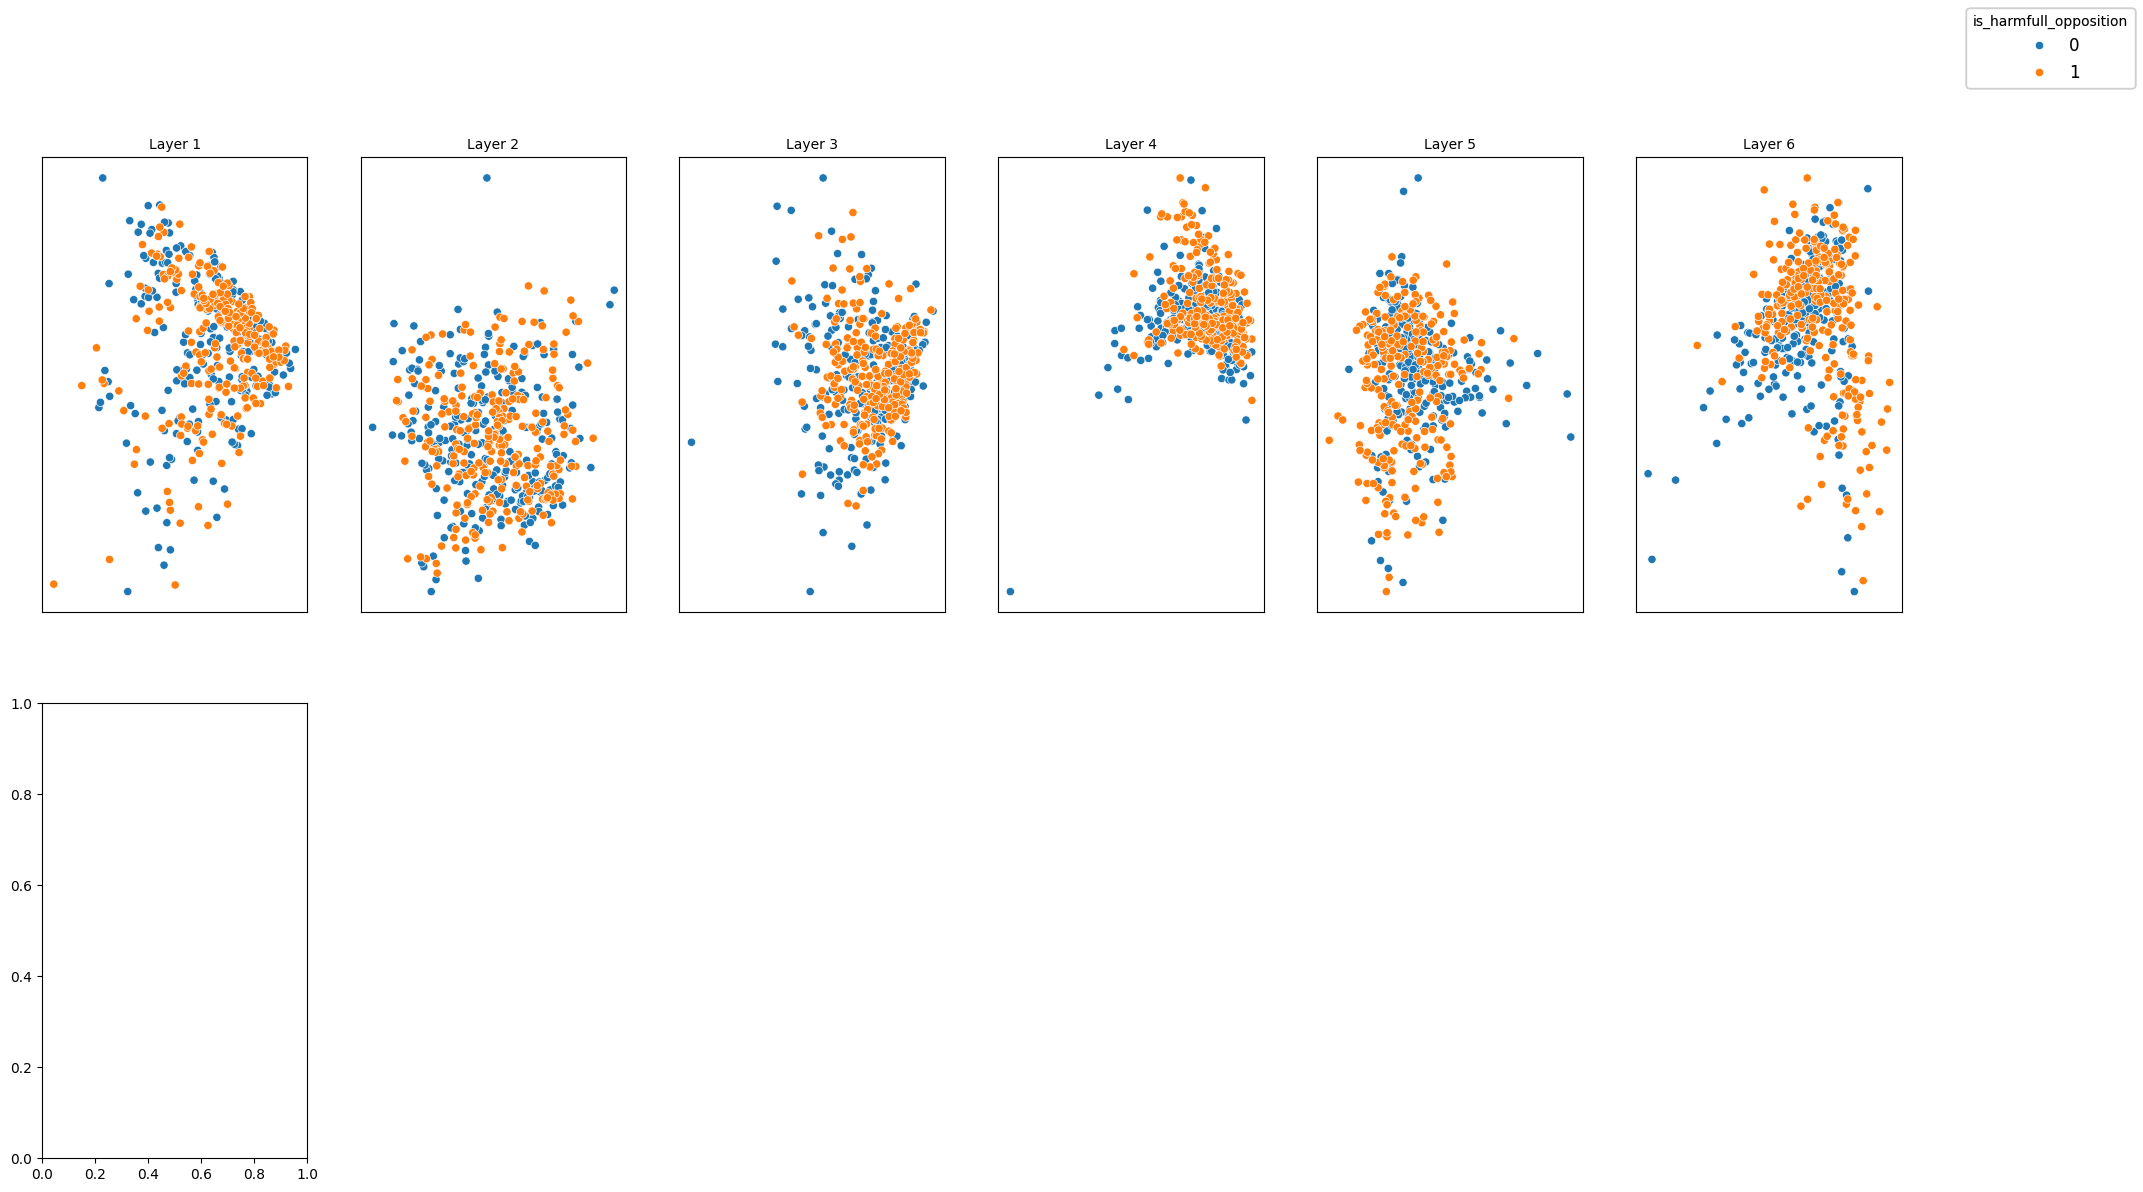

In [84]:
# Components 1, 0
plot_pca_or_tsne_layerwise(X_pos_st_normalized,
                           X_neg_st_normalized,
                           hate_data['is_harmfull_opposition'],
                           standardize=False,
                           n_components=5, components=[0, 1])

In [70]:
steered_ccs = train_ccs_on_hidden_states(X_pos_st_normalized,
                                        X_neg_st_normalized,
                                        hate_data['is_harmfull_opposition'],
                                         train_idx,
                                         test_idx,
                                        normalizing='median')

Median normalize used
Layer 1/7, CCS accuracy: 0.5384615384615384
Median normalize used
Layer 2/7, CCS accuracy: 0.5256410256410257
Median normalize used
Layer 3/7, CCS accuracy: 0.5512820512820513
Median normalize used
Layer 4/7, CCS accuracy: 0.5128205128205128
Median normalize used
Layer 5/7, CCS accuracy: 0.5641025641025641
Median normalize used
Layer 6/7, CCS accuracy: 1.0
Median normalize used
Layer 7/7, CCS accuracy: 1.0


## **7. Plot results tables.**

In [26]:
from format_results import get_results_table

In [27]:
orig_ccs_data = get_results_table(orig_ccs)
st_ccs_data = get_results_table(steered_ccs)

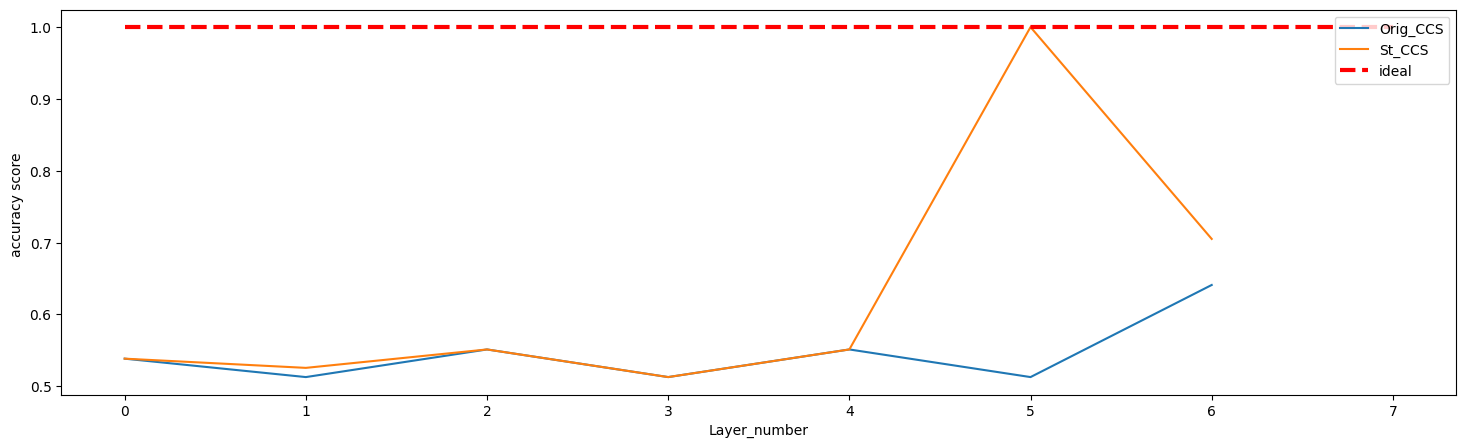

In [28]:
fig, ax = plt.subplots(figsize=(18, 5))

plt.plot(orig_ccs_data['accuracy'], label='Orig_CCS')
plt.plot(st_ccs_data['accuracy'], label='St_CCS')

plt.hlines(1, 0, 7, label='ideal', colors='red', linewidth=3, linestyles=['--'])

plt.xlabel('Layer_number')
plt.ylabel('accuracy score ')
plt.legend(loc='upper right');

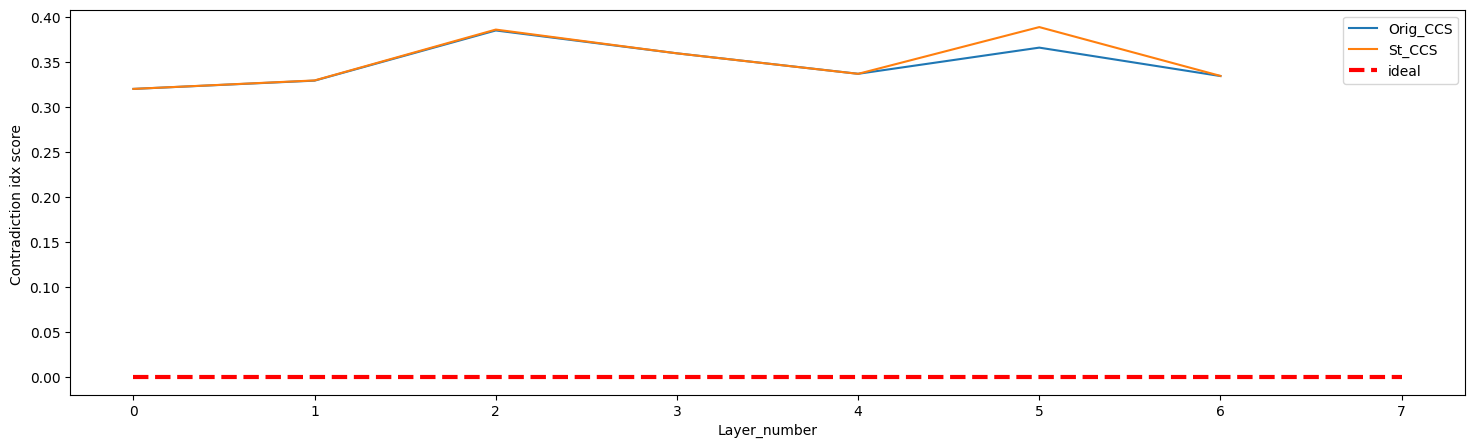

In [29]:
fig, ax = plt.subplots(figsize=(18, 5))

plt.plot(orig_ccs_data['contradiction_idx_↓'], label='Orig_CCS')
plt.plot(st_ccs_data['contradiction_idx_↓'], label='St_CCS')

plt.hlines(0, 0, 7, label='ideal', colors='red', linewidth=3, linestyles=['--'])

plt.xlabel('Layer_number')
plt.ylabel('Contradiction idx score ')
plt.legend(loc='upper right');

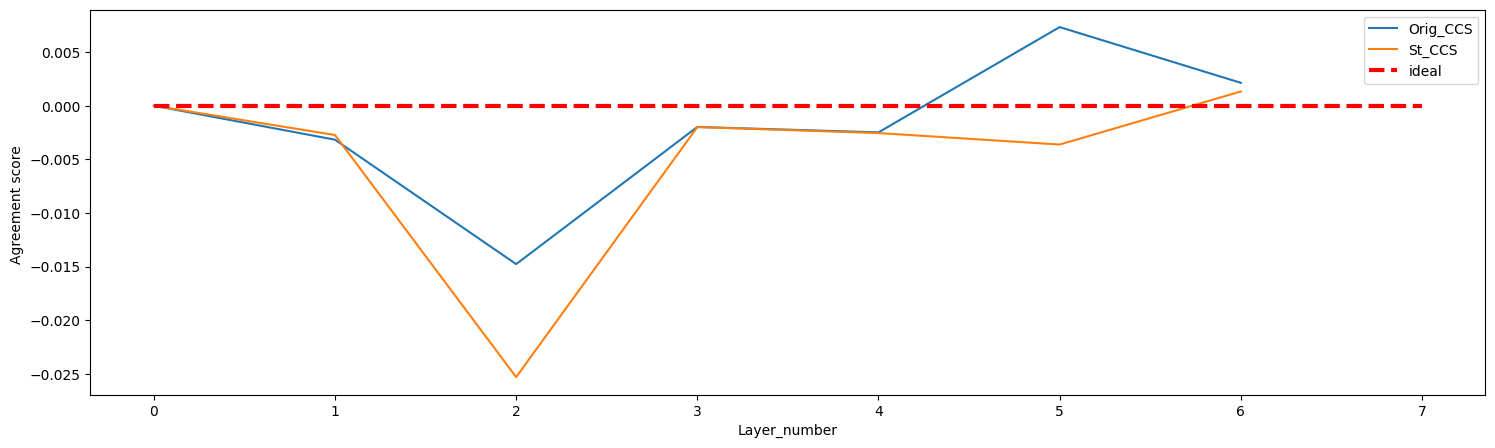

In [30]:
fig, ax = plt.subplots(figsize=(18, 5))

plt.plot(orig_ccs_data['agreement_score_↓'], label='Orig_CCS')
plt.plot(st_ccs_data['agreement_score_↓'], label='St_CCS')

plt.hlines(0, 0, 7, label='ideal', colors='red', linewidth=3, linestyles=['--'])

plt.xlabel('Layer_number')
plt.ylabel('Agreement score ')
plt.legend(loc='upper right');

In [25]:
import torch
from transformers import AutoModel, AutoTokenizer


# === Функция: токеновый attribution
def compute_token_attributions(text, model, tokenizer, theta, bias, layer_idx):
    inputs = tokenizer(text, return_tensors="pt", return_attention_mask=True, padding=True, truncation=True)
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    # Включаем градиенты по embedding
    model.deberta.embeddings.word_embeddings.weight.requires_grad = True

    # Получим embeddings (для backward)
    embeddings = model.deberta.embeddings(input_ids)
    embeddings.retain_grad()

    # Прогон модели с включенным hidden_states
    outputs = model(inputs_embeds=embeddings, attention_mask=attention_mask, output_hidden_states=True)
    h_cls = outputs.hidden_states[layer_idx][0, 0, :]  # [hidden_dim]

    # Вычисляем логит CCS
    logit = torch.dot(h_cls, theta) + bias

    # Градиенты по входу
    model.zero_grad()
    logit.backward()

    # Градиенты embeddings: [batch, seq_len, hidden_dim]
    grads = embeddings.grad[0]  # [seq_len, hidden_dim]

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Attribution по L2 или dot-product с theta
    attributions = (grads * embeddings[0]).sum(dim=1).detach()  # dot-product IG style
    attributions = attributions / attributions.norm(p=1)  # нормировка

    return list(zip(tokens, attributions.tolist())), embeddings.grad


In [26]:
text = hate_yes_data.iloc[:, 1].values.tolist()

inputs = encoder_model_tokenizer(text, return_tensors="pt", return_attention_mask=True, padding=True, truncation=True)
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

    # Включаем градиенты по embedding
encoder_model.deberta.embeddings.word_embeddings.weight.requires_grad = True

    # Получим embeddings (для backward)
embeddings = encoder_model.deberta.embeddings(input_ids)

embeddings.retain_grad()

    # Прогон модели с включенным hidden_states
outputs = encoder_model(inputs_embeds=embeddings, attention_mask=attention_mask, output_hidden_states=True)
h_cls = outputs.hidden_states[LAYER_IDX][:, 0, :]  # [hidden_dim]

    # Вычисляем логит CCS
logit = h_cls @ direction + bias


    # Градиенты по входу
encoder_model.zero_grad()
logit.sum().backward()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [29]:
grads = embeddings.grad # [batch, seq_len, hidden_dim]
print(grads.shape)

torch.Size([514, 36, 768])


In [30]:
tokens = [encoder_model_tokenizer.convert_ids_to_tokens(input_ids[i]) for i in range(input_ids.shape[0])]

In [31]:
# Attribution по L2 или dot-product с theta
attributions_pos = (grads * embeddings).sum(dim=-1).detach()  # dot-product IG style
attributions_pos = attributions_pos / attributions_pos.norm(p=1)  # нормировка

In [ ]:
torch.topk(torch.abs(attributions_pos).sum(0), k=5) # top positive tokens 0, 10, 11, 9

torch.return_types.topk(
values=tensor([0.1625, 0.0649, 0.0595, 0.0578, 0.0567]),
indices=tensor([ 0, 10, 11,  9, 12]))

In [27]:
text = hate_no_data.iloc[:, 1].values.tolist()

inputs = encoder_model_tokenizer(text, return_tensors="pt", return_attention_mask=True, padding=True, truncation=True)
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

    # Включаем градиенты по embedding
encoder_model.deberta.embeddings.word_embeddings.weight.requires_grad = True

    # Получим embeddings (для backward)
embeddings = encoder_model.deberta.embeddings(input_ids)

embeddings.retain_grad()

    # Прогон модели с включенным hidden_states
outputs = encoder_model(inputs_embeds=embeddings, attention_mask=attention_mask, output_hidden_states=True)
h_cls = outputs.hidden_states[LAYER_IDX][:, 0, :]  # [hidden_dim]

    # Вычисляем логит CCS
logit = h_cls @ direction + bias


    # Градиенты по входу
encoder_model.zero_grad()
logit.sum().backward()

grads = embeddings.grad # [batch, seq_len, hidden_dim]
print(grads.shape)

tokens = [encoder_model_tokenizer.convert_ids_to_tokens(input_ids[i]) for i in range(input_ids.shape[0])]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


torch.Size([514, 36, 768])


In [ ]:
# Attribution по L2 или dot-product с theta
attributions_no = (grads * embeddings).sum(dim=-1).detach()  # dot-product IG style
attributions_no = attributions_no / attributions_no.norm(p=1)  # нормировка

torch.topk(torch.abs(attributions_no).sum(0), k=5) # top negative tokens 0, 10, 9, 11

torch.return_types.topk(
values=tensor([0.2889, 0.0645, 0.0627, 0.0603, 0.0534]),
indices=tensor([ 0, 10,  9, 11,  8]))

In [ ]:
# logits = h_cls @ direction  # [B]
# grads = torch.autograd.grad(outputs=logits, inputs=direction,
#                             grad_outputs=torch.eye(len(text)),  # или один-hot
#                             retain_graph=True)

In [149]:
text = hate_yes_data.iloc[:3, 1].values.tolist()
attributions, grad = compute_token_attributions(text, 
encoder_model, encoder_model_tokenizer, 
direction, bias, LAYER_IDX)

scores = []
for string in text:
    attributions, grad = compute_token_attributions(string, 
            encoder_model, encoder_model_tokenizer, 
                direction, bias, LAYER_IDX)
    
    for token, score in attributions:
        print(f"{token:15} {score:+.4f}")

[CLS]           -0.3304
▁Homosexual     +0.0105
s               -0.0518
▁want           -0.0009
▁to             -0.0018
▁have           +0.0149
▁sex            +0.0211
▁with           +0.0316
▁as             -0.0316
▁many           +0.0105
▁different      +0.0475
▁men            +0.0149
▁as             -0.0035
▁possible       +0.0035
.               +0.1441
▁Yes            -0.0211
.               -0.1265
[SEP]           -0.1336
[CLS]           +0.0715
▁Violence       +0.0128
▁against        +0.0664
▁women          +0.0032
▁is             -0.1252
▁a              -0.1277
▁migrant        +0.0613
▁problem        -0.0102
.               +0.2810
▁Yes            +0.0409
.               -0.0568
[SEP]           +0.1430
[CLS]           -0.1885
▁Blacks         -0.0969
▁are            -0.0314
▁just           +0.1361
▁degenerate     +0.0052
s               +0.0419
.               +0.2304
▁Yes            +0.0052
.               -0.0759
[SEP]           -0.1885


In [117]:
grad.shape

torch.Size([1, 10, 768])